# CNN for text classification

This is implementation of [Convolutional Neural Networks for Sentence Classification](https://www.aclweb.org/anthology/D14-1181) paper by Yoon Kim.

- Word2Vec model previously trained is used for embedding
- There is upper limit on sentence sequence 59
- Additional padding is provided by 'end' tag

In [11]:
import pandas as pd
import gc
import torch
from fastai.text import *
from gensim.models import Word2Vec
from torchviz import make_dot

In [5]:
"""Constants"""
PADDING = "<end>"
SEQUENCE_LENGTH = 59
BATCH_SIZE = 50

In [6]:
model_path = "/home/saurabh/Documents/fastai/gradcam_text/data/"
path = Path("/home/saurabh/Documents/fastai/gradcam_text/data/stanford")

## Use word2vec embeddings

- Pytorch embeddings are loaded into embedding layer

In [13]:
language_model = Word2Vec.load(model_path+"/w2v.model")

"""embedding layer"""
weights = torch.FloatTensor(language_model.wv.vectors)
embedding = torch.nn.Embedding.from_pretrained(weights)

""""""
vocab = language_model.wv.vocab
language_model = None

"""Clear the memory"""
gc.collect()

/home/saurabh/.local/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


0

## Load data

In [7]:
def loadData(path, maxwordCount = SEQUENCE_LENGTH):
    df = pd.DataFrame(columns=['sentement', 'text', 'tokens'])
    with open(path) as file:
        line = file.readline()
        index = 0
        while line:
            sentement = int(line[0])
            text = line[2:]
            tokens = text.split()
            
            if len(tokens) > maxwordCount:
                print("Snipping additional tokens")
                tokens = tokens[0:maxwordCount]
                
    
            df.loc[index] = [sentement, text, tokens]
            
            """Append """
            line = file.readline()
            index+=1
    return df

In [8]:
df_train = loadData(path/"stsa.binary.train")
df_test = loadData(path/"stsa.binary.test")

In [9]:
df_train.head()

,sentement,text,tokens
0,1,"a stirring , funny and finally transporting re...","[a, stirring, ,, funny, and, finally, transpor..."
1,0,apparently reassembled from the cutting-room f...,"[apparently, reassembled, from, the, cutting-r..."
2,0,they presume their audience wo n't sit still f...,"[they, presume, their, audience, wo, n't, sit,..."
3,1,this is a visually stunning rumination on love...,"[this, is, a, visually, stunning, rumination, ..."
4,1,jonathan parker 's bartleby should have been t...,"[jonathan, parker, 's, bartleby, should, have,..."


In [14]:
"""Function to tokenize the input text"""
def map_tokens(data, vocab, padding = PADDING, sequence_length = SEQUENCE_LENGTH):
    indexed_tokens = []
    
    for tokens in data:
        indexed_token = []
        for token in tokens:
            if token in vocab:
                indexed_token.append(vocab[token].index)
        
        if len(indexed_token) < sequence_length:
                indexed_token.extend([vocab[padding].index] * (sequence_length - len(indexed_token)))
        indexed_tokens.append(indexed_token)
    return indexed_tokens

In [15]:
x_train = df_train.tokens
x_train = map_tokens(x_train, vocab)
y_train = df_train.sentement
x_train = torch.LongTensor(x_train)
y_train = torch.tensor(y_train)
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)


x_test = df_test.tokens    
x_test = map_tokens(x_test, vocab)
y_test = df_test.sentement
x_test = torch.LongTensor(x_test)
y_test = torch.tensor(y_test)
test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

## Network Structure

In [18]:
class ConvTextNet(nn.Module):
    
    def __init__(self, embedding, embedding_size, sequence_length, classes, keep_probability):
        super().__init__()
        self.embedding = embedding
        self.embedding_size = embedding_size
        self.sequence_length = sequence_length
        self.classes = classes
        self.keep_probability = keep_probability
        
        self._initialize_layers()
    
    
    def _initialize_layers(self):
        
        self.conv_three = torch.nn.Sequential(
                                                torch.nn.Conv2d(in_channels=1, out_channels=512, 
                                                                kernel_size=(3, self.embedding_size),
                                                                stride=(1, self.embedding_size)),
                                                torch.nn.ReLU()
        )


        self.conv_four = torch.nn.Sequential(
                                                torch.nn.Conv2d(in_channels=1, out_channels=512, 
                                                                kernel_size=(4, self.embedding_size), 
                                                                stride=(1, self.embedding_size)),
                                                torch.nn.ReLU()
        )


        self.conv_five = torch.nn.Sequential(
                                                torch.nn.Conv2d(in_channels=1, out_channels=512, 
                                                                kernel_size=(5, self.embedding_size), 
                                                                stride=(1, self.embedding_size)),
                                                torch.nn.ReLU()
        )

    
        self.max_pool_three = torch.nn.Sequential(
                                                 torch.nn.MaxPool2d(kernel_size=(self.sequence_length - 3 + 1, 1))
        )
    
        self.max_pool_four = torch.nn.Sequential(
                                                 torch.nn.MaxPool2d(kernel_size=(self.sequence_length - 4 + 1, 1))
        )

        self.max_pool_five = torch.nn.Sequential(
                                                 torch.nn.MaxPool2d(kernel_size=(self.sequence_length - 5 + 1, 1))
        )
        
        self.fc = torch.nn.Sequential(
                                      torch.nn.Linear(3 * 512, 100),
                                      torch.nn.ReLU(),
                                      torch.nn.Dropout(self.keep_probability),
                                      torch.nn.Linear(100, 50),
                                      torch.nn.ReLU(),
                                      torch.nn.Dropout(self.keep_probability),
                                      torch.nn.Linear(50, self.classes),
        )
        

    def forward(self, x):
        
        out = embedding(x).view(-1, 1, self.sequence_length, self.embedding_size)
        
        out_cnn_three = self.conv_three(out)
        out_cnn_four = self.conv_four(out)
        out_cnn_five = self.conv_five(out)
        
        out_max_three = self.max_pool_three(out_cnn_three)
        out_max_four = self.max_pool_four(out_cnn_four)
        out_max_five = self.max_pool_five(out_cnn_five)
        
        total_filters = 512 * 3
        
        self.concat_layer = torch.cat([out_max_three, out_max_four, out_max_five], 3)
        self.flattened_layer = torch.reshape(self.concat_layer, [-1, total_filters])
        
        out = self.fc(self.flattened_layer)
        return out

    


def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            
            losses_test, nums_test = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
            
            losses_train, nums_train = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in train_dl]
            )            
            
        val_loss_test = np.sum(np.multiply(losses_test, nums_test)) / np.sum(nums_test)
        val_loss_train = np.sum(np.multiply(losses_train, nums_train)) / np.sum(nums_train)
        
        print(epoch, "Train", val_loss_train, "Validation", val_loss_train)

        if epoch%10 == 0:
            f_name = "model_"+str(epoch)+".model"
            torch.save(model, path/f_name)

In [19]:
model = ConvTextNet(embedding, 150, 59, 2, 0.5)
opt = optim.Adam(model.parameters(), lr=1e-4)
loss_func = F.cross_entropy
fit(2, model, loss_func, opt, train_dl, test_dl)

torch.save(model, path/"model_final.model")

0 Train 0.6807114313964899 Validation 0.6807114313964899
1 Train 0.6213606431477332 Validation 0.6213606431477332


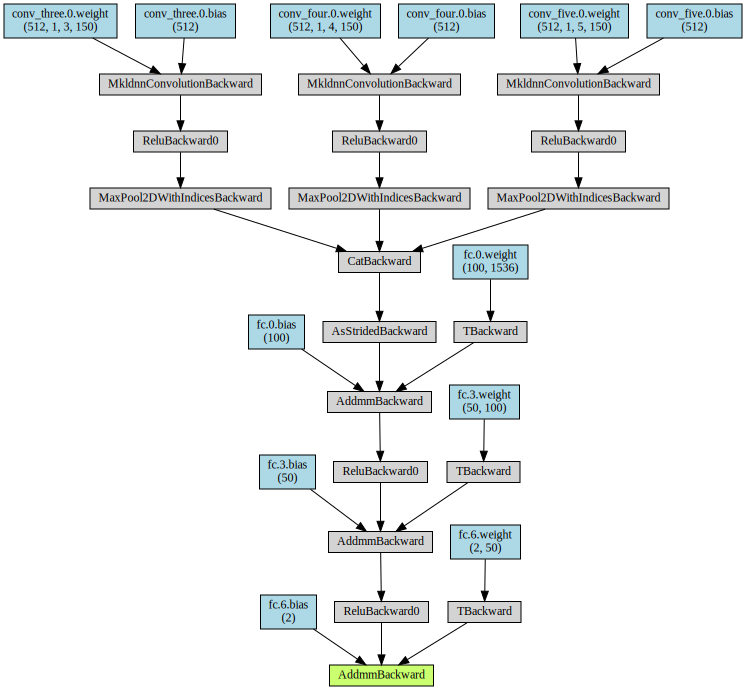

In [25]:
_x, _y = test_ds[4]
make_dot(model(_x), params=dict(model.named_parameters()))

In [22]:
model

ConvTextNet(
  (embedding): Embedding(14830, 150)
  (conv_three): Sequential(
    (0): Conv2d(1, 512, kernel_size=(3, 150), stride=(1, 150))
    (1): ReLU()
  )
  (conv_four): Sequential(
    (0): Conv2d(1, 512, kernel_size=(4, 150), stride=(1, 150))
    (1): ReLU()
  )
  (conv_five): Sequential(
    (0): Conv2d(1, 512, kernel_size=(5, 150), stride=(1, 150))
    (1): ReLU()
  )
  (max_pool_three): Sequential(
    (0): MaxPool2d(kernel_size=(57, 1), stride=(57, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (max_pool_four): Sequential(
    (0): MaxPool2d(kernel_size=(56, 1), stride=(56, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (max_pool_five): Sequential(
    (0): MaxPool2d(kernel_size=(55, 1), stride=(55, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1536, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5)
 